# F20AA Applied Text Analytics: Coursework 2 - Word Embedding Notebook

#### Deadline: 11:59pm, Monday 1st April 2024 via Canvas group space

#### Members:
- Francis Sandrino (fgs2)
- Jai Varsani (jv81)
- Ahmed Moussa Abdelfattah (asa30)
- Aamir Nazir (mn2025)

### What is this?
The purpose of this notebook is to serve as a form of parallelization with different Google Colab accounts to speed up experimentation. This notebook will have minimal documentation, only to aid the group members in understanding the code. The proper documentation, results, and discussion for all processing notebooks is included in the [main file](../amazonCW.ipynb).

### What does this specific notebook deal with?
Experimentation with Word Embeddings.

### Experiment Parameters
These were chosen based on CW 1 results and research.
- Representations: bigrams, trigrams
- Models to test: Vanilla ANN

In [1]:
# This is so I don't have to keep uploading on Colab.

import os
import requests
from requests.auth import HTTPBasicAuth

def downloadFileFromRepo(username, repository, branch, filepath, token):
    # Construct the URL to download the file from GitHub
    url = f"https://raw.githubusercontent.com/{username}/{repository}/{branch}/{filepath}"

    # Send a GET request to download the file
    response = requests.get(url, auth=HTTPBasicAuth(username, token))

    # Check if the request was successful (status code 200)
    if response.status_code == 200:
        # Extract the file name from the URL
        fileName = filepath.split('/')[-1]

        # Create the 'data' directory if it doesn't exist
        if not os.path.exists('data'):
            os.makedirs('data')

        # Define the file path within the 'data' directory
        localFilepath = os.path.join('data', fileName)

        # Write the file content to a local file
        with open(localFilepath, 'wb') as f:
            f.write(response.content)
        print(f"File '{fileName}' downloaded successfully.")
    else:
        print(f"Failed to download file. Status code: {response.status_code}")

username = ""
repository = ""
branch = ""
path_to_file = ""
repoToken = ""
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/data/trainStemmed.csv"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/data/testLemmatized.csv"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/data/testStemmed.csv"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/lemmaTokenizer.json"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

path_to_file = "cw2/stemTokenizer.json"
downloadFileFromRepo(username, repository, branch, path_to_file, repoToken)

File 'trainLemmatized.csv' downloaded successfully.
File 'trainStemmed.csv' downloaded successfully.
File 'testLemmatized.csv' downloaded successfully.
File 'testStemmed.csv' downloaded successfully.
File 'lemmaTokenizer.json' downloaded successfully.
File 'stemTokenizer.json' downloaded successfully.


In [2]:
!pip install --upgrade pip
!pip install tensorflow
!pip install pyyaml h5py

import tensorflow as tf
import nltk
import numpy as np
import pandas as pd

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import StratifiedKFold

nltk.download('wordnet')
nltk.download('punkt')

seed = 50

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [28]:
trainBatchSize = 256

dataset = tf.data.experimental.make_csv_dataset("data/trainLemmatized.csv",
                                                batch_size = trainBatchSize,
                                                select_columns = ["data", "labels"],
                                                label_name = "labels",
                                                num_epochs = 1,
                                                shuffle = True,
                                                shuffle_buffer_size = int(trainBatchSize*1.5))

# Loading tokenizers from the JSON files
with open("data/lemmaTokenizer.json", "r") as json_file:
    tokenizerJSON = json_file.read()
    lemmaTokenizer = tf.keras.preprocessing.text.tokenizer_from_json(tokenizerJSON)
lemmaVocabSize = len(lemmaTokenizer.word_index)
print(lemmaVocabSize)

77413


In [46]:
%%time

from tensorflow.keras.preprocessing.sequence import skipgrams
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Iterator to avoid loading the entire dataset
iterator = iter(dataset)
# To keep track of which batch we're operating on
progress = 0

# For evaluation later
TESTINTERVAL = 1
accuracy = 0
progress = 0
updateAccuracy = 1
maxAccuracy = 0
aveAccuracy = 0
batch_loss = 0
batch_accuracy = 0
losses = []
accuracies = []

model = tf.keras.Sequential([
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
tokenizer = Tokenizer()

try:
  while True:
    # Admin stuff
    progress = progress + 1
    clear_output(wait = True)
    print(f"Batch number: {progress}")
    print(f"Batch loss: {batch_loss}")
    print(f"Batch accuracy: {batch_accuracy}\n")
    print(f"Max accuracy: {maxAccuracy}")
    print(f"Latest accuracy: {accuracy}")
    print(f"Average accuracy: {aveAccuracy}")

    # Obtain batch of text as a list
    batch = next(iterator)
    current = batch[0]['data'].numpy().tolist()
    decoded = list(map((lambda x : x.decode()), current))

    # Generate skipgrams
    features = []
    for i, (text) in enumerate(decoded):
      tokens = text.split()
      pairs, _ = skipgrams(tokens, 77413, window_size=3)
      doc_features = np.zeros(77413)  # Initialize feature vector for current document
      for target_word, _ in pairs:
          target_word_index = lemmaTokenizer.word_index.get(target_word)
          if target_word_index is not None:
              doc_features[target_word_index] = 1  # Set feature to 1 if word is present in skipgram
      features.append(doc_features)

    features_array = np.array(features)
    # Keep track of labels of each batch
    currentLabels = batch[1].numpy().tolist()
    currentLabels = [x - 1 for x in currentLabels]
    currentLabels = tf.keras.utils.to_categorical(currentLabels, num_classes = 5)

    xTrain, xTest, yTrain, yTest = train_test_split(features_array, currentLabels, test_size=0.15, random_state=42)
    history = model.fit(xTrain, yTrain, batch_size = trainBatchSize, validation_data = (xTest, yTest))
    batch_loss = history.history['loss']
    batch_accuracy = history.history['accuracy']
    loss = history.history['val_loss'][0]
    accuracy = history.history['val_accuracy'][0]
    losses.append(loss)
    accuracies.append(accuracy)
    aveAccuracy = (((aveAccuracy * (progress - 1)) + accuracy) / (progress / updateAccuracy))
    if maxAccuracy < accuracy:
        maxAccuracy = accuracy
    # updateAccuracy = updateAccuracy + TESTINTERVAL
except StopIteration:
  print("End of iterator reached.")

Batch number: 1447
Batch loss: [0.6398815512657166]
Batch accuracy: [0.7880184054374695]

Max accuracy: 0.9743589758872986
Latest accuracy: 0.7948718070983887
Average accuracy: 0.7941802442073822


IndexError: index 77413 is out of bounds for axis 0 with size 77413

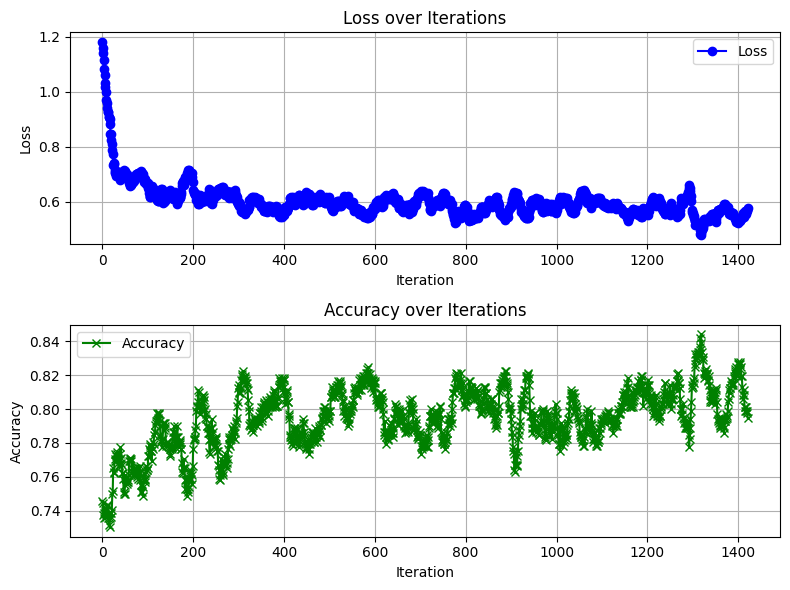

In [47]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

def movingAverage(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    smooth = np.convolve(data, weights, 'valid')
    return smooth

# Define window size for smoothing (adjust as needed)
window_size = 25

smoothedL = movingAverage(losses, window_size)
smoothedA = movingAverage(accuracies, window_size)

# Plot losses on the first subplot
axs[0].plot(smoothedL, marker='o', label='Loss', color='blue')  # 'o' for markers at data points
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over Iterations')
axs[0].legend()  # Show legend with labels
axs[0].grid(True)  # Enable grid

# Plot accuracies on the second subplot
axs[1].plot(smoothedA, marker='x', label='Accuracy', color='green')  # 'x' for different markers
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over Iterations')
axs[1].legend()  # Show legend with labels
axs[1].grid(True)  # Enable grid

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [50]:
%%time

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding

# Iterator to avoid loading the entire dataset
iterator = iter(dataset)
# To keep track of which batch we're operating on
progress = 0

# For evaluation later
TESTINTERVAL = 1
accuracy = 0
progress = 0
updateAccuracy = 1
maxAccuracy = 0
aveAccuracy = 0
batch_loss = 0
batch_accuracy = 0
losses = []
accuracies = []

model = tf.keras.Sequential([
    Embedding(input_dim = 77413, output_dim = 256),
    tf.keras.layers.GlobalAveragePooling1D(),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(5, activation='softmax')
])

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

try:
  while True:
    # Admin stuff
    progress = progress + 1
    clear_output(wait = True)
    print(f"Batch number: {progress}")
    print(f"Batch loss: {batch_loss}")
    print(f"Batch accuracy: {batch_accuracy}\n")
    print(f"Max accuracy: {maxAccuracy}")
    print(f"Latest accuracy: {accuracy}")
    print(f"Average accuracy: {aveAccuracy}")

    # Obtain batch of text as a list
    batch = next(iterator)
    current = batch[0]['data'].numpy().tolist()
    decoded = list(map((lambda x : x.decode()), current))
    tokenizedDocs = lemmaTokenizer.texts_to_sequences(decoded)
    paddedData=tf.keras.preprocessing.sequence.pad_sequences(tokenizedDocs, maxlen=1885, padding="post")

    # Keep track of labels of each batch
    currentLabels = batch[1].numpy().tolist()
    currentLabels = [x - 1 for x in currentLabels]
    currentLabels = tf.keras.utils.to_categorical(currentLabels, num_classes = 5)

    xTrain, xTest, yTrain, yTest = train_test_split(paddedData, currentLabels, test_size=0.15, random_state=42)
    history = model.fit(xTrain, yTrain, batch_size = trainBatchSize, validation_data = (xTest, yTest))
    batch_loss = history.history['loss']
    batch_accuracy = history.history['accuracy']
    loss = history.history['val_loss'][0]
    accuracy = history.history['val_accuracy'][0]
    losses.append(loss)
    accuracies.append(accuracy)
    aveAccuracy = (((aveAccuracy * (progress - 1)) + accuracy) / (progress / updateAccuracy))
    if maxAccuracy < accuracy:
        maxAccuracy = accuracy
    # updateAccuracy = updateAccuracy + TESTINTERVAL
except StopIteration:
  print("End of iterator reached.")

Batch number: 1449
Batch loss: [0.7624155282974243]
Batch accuracy: [0.739130437374115]

Max accuracy: 0.9487179517745972
Latest accuracy: 0.800000011920929
Average accuracy: 0.7638688340206825
End of iterator reached.
CPU times: user 5min 28s, sys: 10.4 s, total: 5min 38s
Wall time: 6min 46s


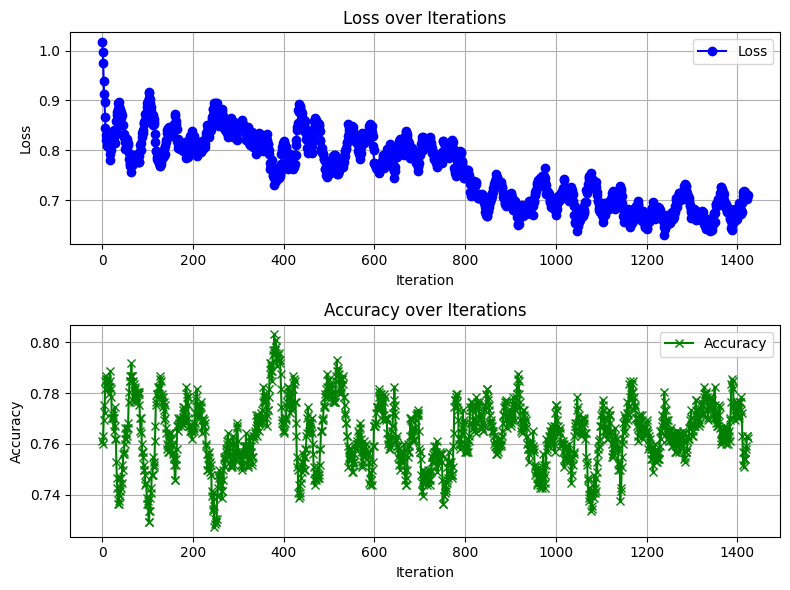

In [51]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 1, figsize=(8, 6))

def movingAverage(data, window_size):
    weights = np.repeat(1.0, window_size) / window_size
    smooth = np.convolve(data, weights, 'valid')
    return smooth

# Define window size for smoothing (adjust as needed)
window_size = 25

smoothedL = movingAverage(losses, window_size)
smoothedA = movingAverage(accuracies, window_size)

# Plot losses on the first subplot
axs[0].plot(smoothedL, marker='o', label='Loss', color='blue')  # 'o' for markers at data points
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Loss')
axs[0].set_title('Loss over Iterations')
axs[0].legend()  # Show legend with labels
axs[0].grid(True)  # Enable grid

# Plot accuracies on the second subplot
axs[1].plot(smoothedA, marker='x', label='Accuracy', color='green')  # 'x' for different markers
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Accuracy over Iterations')
axs[1].legend()  # Show legend with labels
axs[1].grid(True)  # Enable grid

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()